# CS 168 Spring Assignment 2

SUNet ID(s): 05794739

Name(s): Luis A. Perez

Collaborators: None

By turning in this assignment, I agree by the Stanford honor code and declare
that all of this is my own work.


# Imports

In [1]:
import collections
import matplotlib.pyplot as plt
import scipy

import numpy as np
import pandas as pd
import seaborn as sns
import os
import warnings

from typing import Dict, List, Text, Tuple

# Make figure larger
plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
class Globals:
    """Class holding globals to avoid polluting workspace."""
    DATA_DIR: Text = 'p2_data'
    LABEL: Text = 'label.csv'
    GROUPS: Text = 'groups.csv'
    DATA: Text = 'data50.csv'

In [3]:
def makeHeatMap(data, names, color, outputFileName):
    """Makes a 20x20 heatmap from the given 20x20 data matrix."""
    # to catch "falling back to Agg" warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # code source: http://stackoverflow.com/questions/14391959/heatmap-in-matplotlib-with-pcolor
        fig, ax = plt.subplots()
        # create the map w/ color bar legend
        heatmap = ax.pcolor(data, cmap=color)
        cbar = plt.colorbar(heatmap)

        # put the major ticks at the middle of each cell
        ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
        ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)

        # want a more natural, table-like display
        ax.invert_yaxis()
        ax.xaxis.tick_top()

        ax.set_xticklabels(range(1, 21))
        ax.set_yticklabels(names)

        plt.tight_layout()

        plt.savefig(outputFileName, format='png')
        plt.close()

In [4]:
def read_data() -> Tuple[Dict[int, int], Dict[int, List[int]], pd.DataFrame]:
    """Reads the relevant data files.
    
    Returns:
        A tuple of items. The bag of words object and for each 
        article (keyed by articleId) and a mapping from
        groupId to a list of corresponding articleIds in that group.
        Also the entire dataset as a pd.DataFrame.
    """
    # Maps to groupId.
    labels = pd.read_csv(
        os.path.join(Globals.DATA_DIR, Globals.LABEL), header=None,
        names=['groupId'])
    labels['articleId'] = range(1, len(labels) + 1)
    # Maps to groupName.
    groups = pd.read_csv(
        os.path.join(Globals.DATA_DIR,
                     Globals.GROUPS), header=None,
        names=['name'])
    groups['groupId'] = range(1, len(groups) + 1)
    data = pd.read_csv(
        os.path.join(Globals.DATA_DIR, Globals.DATA), header=None,
        names=['articleId', 'wordId', 'count'])
    data = data.merge(labels, on='articleId').merge(groups, on='groupId')
    
    numArticles = max(data.articleId)
    numWords = max(data.wordId)
    # Load into a sparse matrix of (numArticles x numWords)
    sparse_data = np.array(data['count'])
    row_idx = np.array(data['articleId']) - 1
    col_idx = np.array(data['wordId']) - 1
    sparse_matrix = scipy.sparse.csr_matrix((sparse_data, (row_idx, col_idx)), shape=(numArticles, numWords))
    
    # Transform into a dictionary mapping articleId to a collections.Counter
    # object counting each word (based on wordId).
    group_to_name = {groupId : data[data.groupId == groupId].name.iloc[0]
                    for groupId in data.groupId.unique()}
    article_to_group = {articleId : data[data.articleId == articleId].groupId.iloc[0]
            for articleId in data.articleId.unique()}
    group_to_article = { groupId : data[data.groupId == groupId].articleId.unique()
                       for groupId in data.groupId.unique()}
    return sparse_matrix, group_to_article, group_to_name, article_to_group

In [5]:
def l2_dist(X, Y):
    """Computes the L2 pairwise distance between all elements in X,Y.
    
    Args:
        X: An (n,k) matrix where each row is an element.
        Y: An (m,k) matrix where each row is an element.
        
    Returns:
        D: An (n,m) matrix where D[i][j] is the distance L2 distance
            between X[i,:] and Y[j,:].
    """
    (n,k1), (m, k2) = np.shape(X), np.shape(Y)
    assert k1 == k2
    k = k1
    X2 = np.diag(np.dot(X, X.T).todense()).reshape((n, 1))
    Y2 = np.diag(np.dot(Y, Y.T).todense()).reshape((1, m))
    XY = np.dot(X, Y.T)
    return -np.sqrt(X2 + Y2 - 2*XY)

In [6]:
def cosine_dist(X, Y):
    """Computes the cosine pairwise distance between all elements in X,Y.
    
    Args:
        X: An (n,k) matrix where each row is an element.
        Y: An (m,k) matrix where each row is an element.
        
    Returns:
        D: An (n,m) matrix where D[i][j] is the distance L2 distance
            between X[i,:] and Y[j,:].
    """
    (n,k1), (m, k2) = np.shape(X), np.shape(Y)
    assert k1 == k2
    k = k1
    Xnorm = np.sqrt(np.diag(np.dot(X, X.T).todense()).reshape((n, 1)))
    Ynorm = np.sqrt(np.diag(np.dot(Y, Y.T).todense()).reshape((1, m)))
    XY = np.dot(X, Y.T)
    return XY / np.multiply(Xnorm, Ynorm)

In [7]:
def jaccard_dist(X, Y):
    """Computes the Jaccard pairwise distance between all elements in X,Y.
    
    Args:
        X: An (n,k) matrix where each row is an element.
        Y: An (m,k) matrix where each row is an element.
        
    Returns:
        D: An (n,m) matrix where D[i][j] is the distance L2 distance
            between X[i,:] and Y[j,:].
    """
    (n,k1), (m, k2) = np.shape(X), np.shape(Y)
    assert k1 == k2
    k = k1
    
    def ones_on_col(i):
        row_ind = [k for k in range(n)]
        col_ind = [i for _ in range(m)]
        data = np.ones(m)
        return scipy.sparse.csr_matrix((data, (row_ind, col_ind)), shape=(n, n))
    
    # Duplicate X to be [X, X, X, ... X] m times (so just stack them).
    stackedX = scipy.sparse.vstack(X for _ in range(m))
    # Duplicate the rows if Y each n times.
    duplicatedY = np.dot(scipy.sparse.vstack(ones_on_col(row) for row in range(m)), Y)
    mins = stackedX.minimum(duplicatedY) # (n x m) x k
    maxs = stackedX.maximum(duplicatedY) # (n x m) x k
    minSums = np.sum(mins, axis=1).reshape((n,m))
    maxSums = np.sum(maxs, axis=1).reshape((n,m))
    return (minSums / maxSums)

In [8]:
def average_similarity(distances, groupA, groupB) -> float:
    """Computes the average similarity between the two specified groups.
    
    Args:
        distances: A distance matrix computing all distances between all articles.
        groupA: A list of articleIdx belong to groupA.
        groupB: A list of articleIdx belong to groupB.
    
    Returns:
        The average of the similarities between all pairings in A and B.
    """
    # Even though all of our existing sim_fn are symmetric, do
    # all pairs in-case this doesn't hold true in general.
    scores = [distances[Aidx - 1, Bidx - 1]
              for Aidx in groupA for Bidx in groupB]
    return np.mean(scores)

In [9]:
def get_similarity_matrix(db, groups_to_articles, sim_fn, max_groups=None):
    """Computes the similarity matrix using the given sim_fn for all groups.
    
    Args:
        db: Sparse matrix where each row is an article.
        groups_to_articles: Mapping from groupIdx to a list of articleIdx belong to that group.
        sim_fn: Similarity function to use.
    
    Returns:
        A 20x20 matrix with the average similarity between all pairs of groups.
    """
    groups = sorted(groups_to_articles.keys())
    # Similarity between all pairs of articles.
    D = sim_fn(db, db)
    data = np.zeros((20,20))
    for i, groupA in enumerate(groups):
        for j, groupB in enumerate(groups):
            data[i][j] = average_similarity(
                D, groups_to_articles[groupA], groups_to_articles[groupB])
    return data

In [10]:
def get_all_sim_matrices(articles, groups_to_articles, sim_fns):
    """Computes all similarity matrices for all given sim_fns."""
    data = {}
    for name, sim_fn in sim_fns.items():
        data[name] = get_similarity_matrix(articles, groups_to_articles, sim_fn)
    return data

In [11]:
def plot_heatmaps(input_data, sim_fns):
    """Plots and saves heatmaps for different similarity functions."""
    articles, groups_to_articles, group_names, _ = input_data
    names = [group_names[i] for i in sorted(group_names.keys())]
    all_data = get_all_sim_matrices(articles, groups_to_articles, sim_fns)
    for name, data in all_data.items():
        makeHeatMap(data, names, color='Blues',
                    outputFileName="figures/{name}.png".format(name=name))

## Problem 1

In [12]:
def problem_1b():
    """Solves problem 2b from Mini-Project 2"""
    input_data = read_data()
    plot_heatmaps(input_data, {
        'Cosine' : cosine_dist,
        'Jaccard': jaccard_dist,
        'L2' : l2_dist })

In [13]:
problem_1b()

## Problem 2

In [14]:
def find_nearest_neighbor(database, sim_fn):
    """Finds the nearest neighbor document in the database to all other documents.
    
    Args:
        database: Sparse matrix with all possible articles.
        sim_fn: The similarity functions to use.
    
    Returns:
        The articleIdx corresponding to the nearest neighbors.
    """
    D = sim_fn(database, database) # (n, n)
    (n, _) = D.shape
    # Ignore self-similarity by making it smaller than everything else.
    D = D - 10*(D.max() * np.identity(n))
    # Take the argmax to get the article indeces. +1 to move to articleIdx space.
    return np.array(D.argmax(axis=0)).flatten() + 1

In [15]:
def classification_count(groupA, neighbor_group, groupBId):
    """Counts the number of articles in groupA whose nearest neighbor is in groupB."""
    return len([1 for articleId in groupA
                if neighbor_group[articleId] == groupBId])

In [16]:
def get_classification_matrix(db, groups_to_articles, article_to_groups, sim_fn, nearest_neigbor_fn):
    """Computes the similarity matrix using the given sim_fn for all groups."""
    # array[i - 1] gives articleIdx of nearest neighbor.
    article_to_neighbor = nearest_neigbor_fn(db, sim_fn)
    neighbor_group = { articleId : article_to_groups[article_to_neighbor[articleId - 1]]
                      for articleId in article_to_groups }
    data = np.zeros((20, 20))
    groups = sorted(groups_to_articles.keys())
    for i, groupA in enumerate(groups):
        for j, groupB in enumerate(groups):
            data[i][j] = classification_count(
                groups_to_articles[groupA], neighbor_group, groupB)
    return data

In [17]:
def plotHeatMaps2(db, groups_to_articles, group_names, article_to_group, figName, nearest_neigbor_fn):
    data = get_classification_matrix(db, groups_to_articles, article_to_group, cosine_dist, nearest_neigbor_fn)
    names = [group_names[i] for i in sorted(group_names.keys())]
    makeHeatMap(data, names, color='Blues',
                    outputFileName="figures/{name}.png".format(name=figName))
    # Diagonal counts are articles belonging to group X whose nearest neighbor
    # also belong to the same group.
    accuracy = 100*data.diagonal().sum() / data.sum()
    print("Classification accuracy: {:.2f}% for {}".format(accuracy, figName))
    return accuracy

In [18]:
def problem2a():
    plotHeatMaps2(*read_data(), figName='classification', nearest_neigbor_fn=find_nearest_neighbor)

In [19]:
problem2a()

Classification accuracy: 45.60% for classification


In [20]:
def random_projection(db, d: int):
    (n, k) = db.shape
    M = scipy.sparse.csr_matrix(np.random.normal(size=(d, k)))
    return np.dot(db, M.T) # (n, d)

def problem2c():
    db, groups_to_articles, group_names, article_to_group = read_data()
    
    for d in [10, 25, 50, 100]:
        db = random_projection(db, d)
        plotHeatMaps2(db, groups_to_articles,
                      group_names, article_to_group, figName="classification_d=%s" % d,
                      nearest_neigbor_fn=find_nearest_neighbor)

In [21]:
problem2c()

Classification accuracy: 14.60% for classification_d=10
Classification accuracy: 12.60% for classification_d=25
Classification accuracy: 12.30% for classification_d=50
Classification accuracy: 12.40% for classification_d=100


# Problem 3

In [22]:
class RandomHyperplaneClassifier:
    def __init__(self, d: int, k: int, l: int):
        """Initializes the RandomHyperplaneHasher.

        Given a vector x \in R^k, the for each hash table we compute
        hash = bucket(Mx) where M is drawn uniformly at random (but fixed)
        for each hash table and bucket returns the corresponding digit in
        [0, 2^d-1].

        Args:
            l: The number of hash tables to construct.
            d: Each hash table will have 2^d buckets.
        """
        # Each hash table points to a list of tuples of (articleIdx, article) that
        # hashed to that bucket.
        self.d = d
        self.l = l
        self.k = k
        self.hash_tables = [{} for _ in range(l)]
        self.hash_matrices = [
            scipy.sparse.csr_matrix(np.random.normal(size=(d, k)))
            for _ in range(l)]
        self._powerMatrix = np.array([2**i for i in range(d)]).reshape((1, d))
        self._db = None
        
    def _hash(self, db):
        """Computes the l hash values of all provided elements.
        
        Args:
            db: (n, k) matrix of n elements to be hashed.
            
        Returns:
            A list of l numpy arrays of shape [n] specifying the indexes
            for each of the n elements into the l-th hash table.
        """
        hashes = []
        n, _ = db.shape
        for i, M in enumerate(self.hash_matrices):
            P = np.dot(db, M.T).todense() # (n,d)
            n, d = P.shape
            P[P > 0] = 1
            P[P <= 0] = 0
            indices = np.array(np.sum(
                np.multiply(P,  self._powerMatrix), axis=1)).flatten().astype(int)
            hashes.append(indices)
        return hashes
    
    def _load(self):
        """Computes the load of each hash table. Load is defined as average number of elements per bucket."""
        return [np.mean([len(els) for els in table.values()]) * len(table) / 2**self.d
                for table in self.hash_tables]
    
    def add(self, db):
        """Adds the given set of elements to the hasher. Should only be called once.
        
        Args:
            db: An (nxk) sparse matrix where each row corresponds to an element
                to be added to the hasher.
        """
        assert not self._db
        print("Adding elements for d=%s, l=%s" % (self.d, self.l))
        all_hashes = self._hash(db)
        for m, element_hashes in enumerate(all_hashes):
            table = self.hash_tables[m]
            for row_idx, element_hash in enumerate(element_hashes):
                if element_hash in table:
                    table[element_hash].append((row_idx + 1, db.getrow(row_idx)))
                else:
                    table[element_hash] = [(row_idx + 1, db.getrow(row_idx))]
        self._db = db
        print("Added elements for d=%s, l=%s" % (self.d, self.l))
        return True
                
    def neighbors(self, db):
        """Classifies the elements.
        
        Args:
            db: A matrix [n,k] of n elements to classify.
        
        Returns:
            A list of n integers specifying the articleIdx of the closest neighbor.
        """
        print("Getting neighbors elements for d=%s, l=%s" % (self.d, self.l))
        all_hashes = self._hash(db)
        n, _ = db.shape
        sq = [[] for i in range(n)] # List of sq for each datapoint.
        sq_indexes = [[] for _ in range(n)] # Each inner list maps sq[i][j] to sq_indexes[i][j].
        sq_sets = [set() for _ in range(n)] # Each inner list is a set of the unique elements included in sq_indexes[i][j]
        our_document_idx = [] # Gives us the idx in sq* that corresponds to our document.
        for m, element_hashes in enumerate(all_hashes):
            table = self.hash_tables[m]
            for row_idx, element_hash in enumerate(element_hashes):
                if element_hash in table:
                    for articleIdx, article in self.hash_tables[m][element_hash]:
                        if articleIdx not in sq_sets[row_idx]:
                            sq_sets[row_idx].add(articleIdx)
                            sq[row_idx].append(article)
                            sq_indexes[row_idx].append(articleIdx)
                            if (row_idx + 1) == articleIdx:
                                our_document_idx.append(len(sq[row_idx]) - 1)
        
        sq_matrices = [scipy.sparse.vstack(sqs) for sqs in sq]
        average_size = np.mean([len(sqs) for sqs in sq])
        print("Average size of SQ is %s for d=%s, l=%s, k=%s" %(average_size, self.d, self.l, self.k))
        
        # Create sparse matrices.
        nearest_neighbors = []
        for our_doc, sq_matrix, sq_index in zip(our_document_idx, sq_matrices, sq_indexes):
            idxes = find_nearest_neighbor(sq_matrix, cosine_dist) - 1 # (#sq, #sq)
            # Our document is the first row, map back to full databses.
            neighbor_idx = sq_index[idxes[our_doc]]
            nearest_neighbors.append(neighbor_idx)
        
        print("Got neighbors elements for d=%s, l=%s" % (self.d, self.l))
        

        return np.array(nearest_neighbors), average_size
            

In [23]:
def problem3d():
    l = 128
    data = read_data()
    n, k = data[0].shape
    sizes = []
    accuracies = []
    for d in range(5, 21):
        global avg_size = None
        def nn(db, sim_fn):
            hasher = RandomHyperplaneClassifier(d=d, l=128, k=k)
            hasher.add(db)
            nns, avg_size = hasher.neighbors(db)
            return nns

        accuracy = plotHeatMaps2(*data, figName='local_sensitivity_hashing_l=%s_d=%s' % (l, d),
                                 nearest_neigbor_fn=nn)
        sizes.append(avg_size)
        accuracies.append(accuracy)
    return sizes, accuracies

In [24]:
sizes, accuracies = problem3d()

Adding elements for d=5, l=128
Added elements for d=5, l=128
Getting neighbors elements for d=5, l=128
Average size of SQ is 999.172 for d=5, l=128, k=61067
Got neighbors elements for d=5, l=128
Classification accuracy: 45.60% for local_sensitivity_hashing_l=128_d=5
Adding elements for d=6, l=128
Added elements for d=6, l=128
Getting neighbors elements for d=6, l=128
Average size of SQ is 987.826 for d=6, l=128, k=61067
Got neighbors elements for d=6, l=128
Classification accuracy: 45.60% for local_sensitivity_hashing_l=128_d=6
Adding elements for d=7, l=128
Added elements for d=7, l=128
Getting neighbors elements for d=7, l=128
Average size of SQ is 940.396 for d=7, l=128, k=61067
Got neighbors elements for d=7, l=128
Classification accuracy: 45.60% for local_sensitivity_hashing_l=128_d=7
Adding elements for d=8, l=128
Added elements for d=8, l=128
Getting neighbors elements for d=8, l=128
Average size of SQ is 858.53 for d=8, l=128, k=61067
Got neighbors elements for d=8, l=128
Class

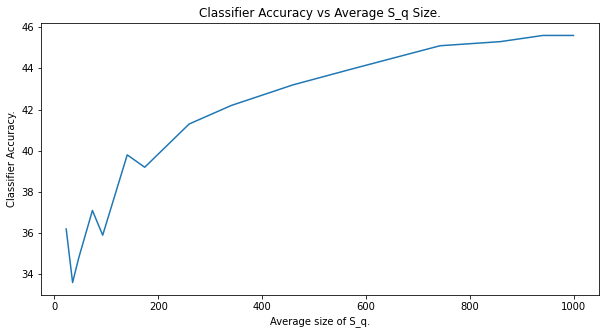

In [41]:
plt.title("Classifier Accuracy vs Average S_q Size.")
plt.ylabel('Classifier Accuracy.')
plt.xlabel('Average size of S_q.')
plt.plot(sizes, accuracies)
plt.savefig("figures/Classifier_vs_s_q_size.png", format='png')